In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
plt.style.use('dark_background')

# Read Input Image

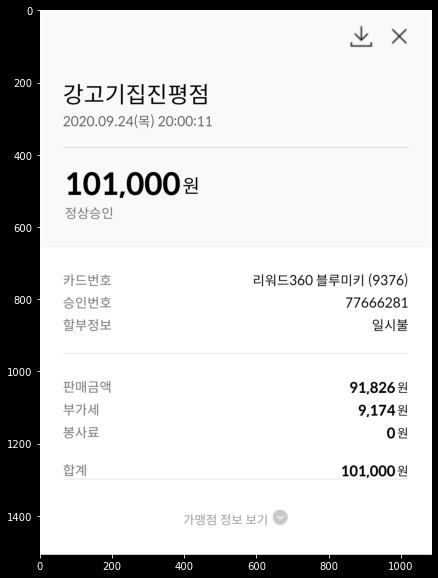

In [21]:
img_ori = cv2.imread(r'C:\Users\multicampus\Desktop\s03p23d202\textdetection\payco.png')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

# Convert Image to Grayscale

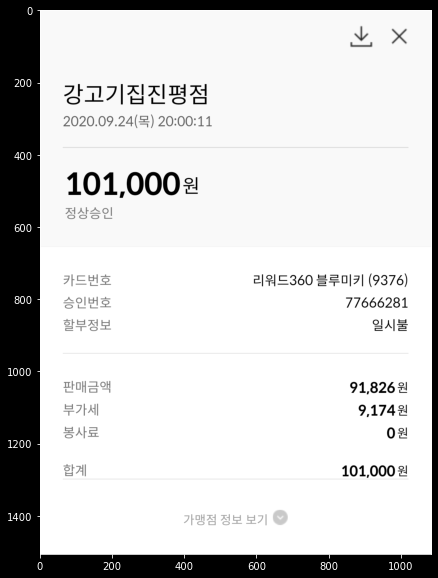

In [22]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Maximize Contrast (Optional)

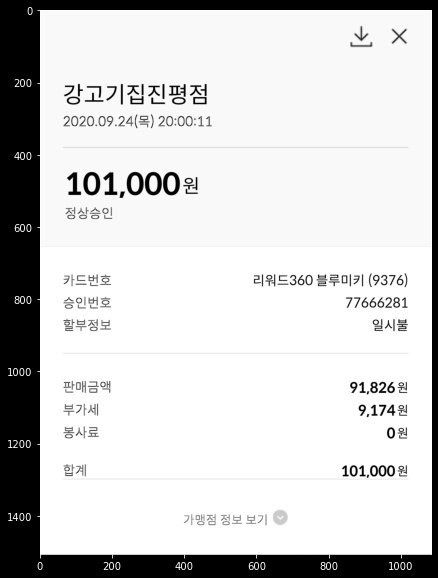

In [23]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Adaptive Thresholding

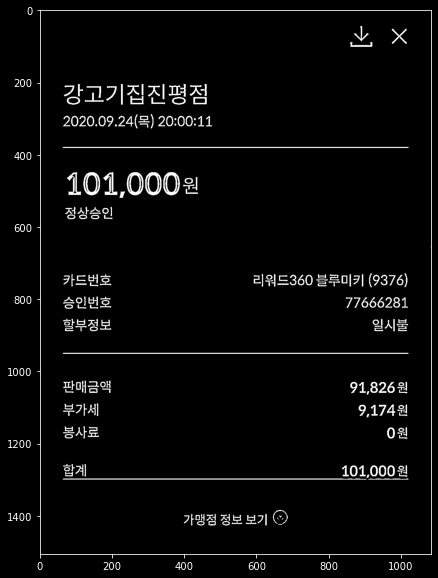

In [24]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=11, 
    C=5
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# Find Contours¶

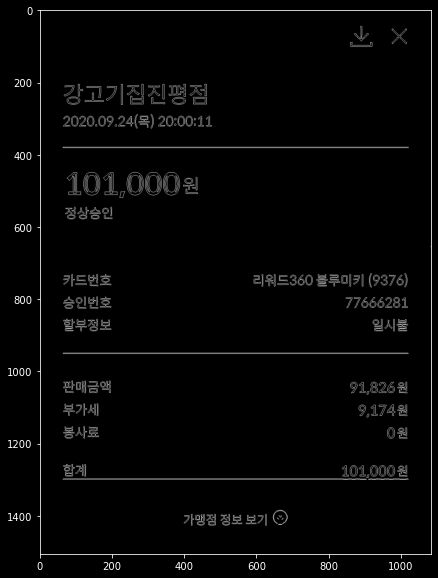

In [27]:
# _, contours, _ = cv2.findContours(
contours, hierarchy = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

# plt.figure(figsize=(30, 26))
plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# Prepare Data

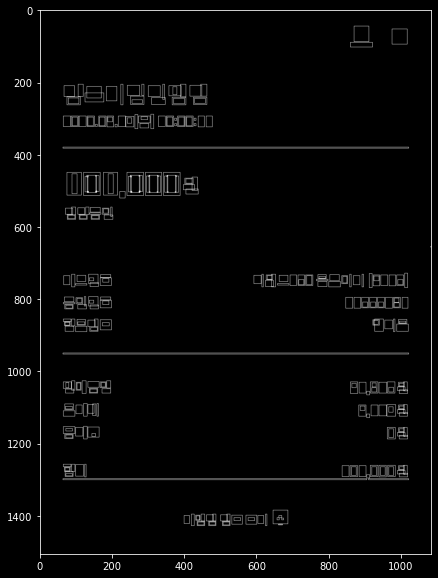

In [28]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(30, 26))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Char Size

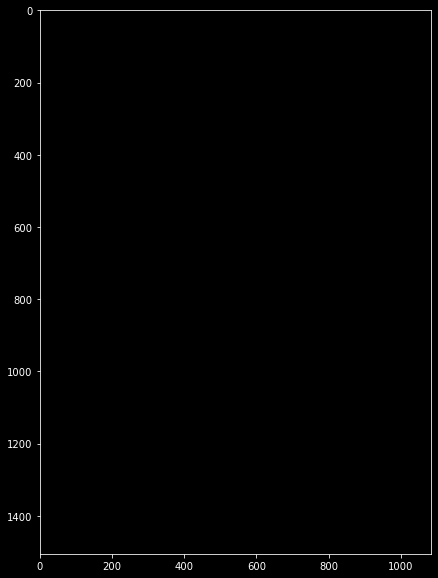

In [29]:
MIN_AREA = 5000
# 가로*세로 
MIN_WIDTH, MIN_HEIGHT = 250,50
# 대충 가로 글자 1개당 40정도 세로 50정도
MIN_RATIO, MAX_RATIO = 4.0, 8.0
# 이 부분을 글자수-2, 글자수+2 정도로 변수화 하면 될 듯

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    final_cx = d['cx']
    final_cy = d['cy']
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# crop found letter part of total image

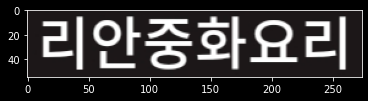

In [69]:
# 잘려진 사진을 담을 배열, 정보 배열
final_img = []
final_info = []

# 자를 사진의 가로,세로 길이
final_w = int(MIN_WIDTH) + 4*6
final_h = int(MIN_HEIGHT) + 5

#자른 사진
img_cropped = cv2.getRectSubPix(
        img_ori, 
        patchSize=(final_w, final_h) ,
        center=(int(final_cx), int(final_cy))
    )
        
    
final_img.append(img_cropped)
final_info.append({
    'x': int(final_cx - final_w / 2),
    'y': int(final_cy - final_h / 2),
    'w': int(final_w),
    'h': int(final_h)
})


plt.imshow(img_cropped, cmap='gray')

# Another Thresholding to Find Chars¶

리안중화요리


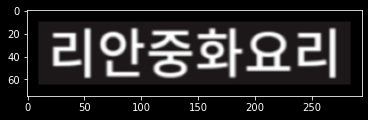

In [59]:
img_result = img_cropped
    
img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
# _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')

result_chars = ''
has_digit = False
for c in chars:
    if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
        if c.isdigit():
            has_digit = True
        result_chars += c

print(result_chars)


plt.imshow(img_result, cmap='gray')

# Result

방문한 식당 이름 :  리안중화요리


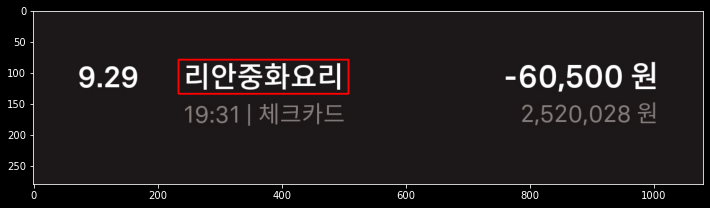

In [68]:
info = final_info[0]
img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(result_chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)

print('방문한 식당 이름 : ', result_chars)